# Parcial 1 Machine Learning. Binary Classifier.

## Funciones y librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## Funciones auxiliares

In [2]:
## Calculo de los IV (Funcion sacada de https://www.kaggle.com/code/puremath86/iv-woe-starter-for-python/notebook)
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    #print('El IV de esta variable es:',iv)
    #print(df[feature].value_counts())
    return iv, data

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta')
    plt.xlabel('Predicción')

## Preprocesamiento

In [4]:
# Se obtienen los datos de los archivos de texto plano
xtrain = pd.read_csv("datos/xtrain.txt", sep="   ", header=None, engine='python')
ytrain = pd.read_csv("datos/ytrain.txt", sep="   ", header=None, engine='python')
xtest = pd.read_csv("datos/xtest.txt", sep="   ", header=None, engine='python')

In [5]:
# Creo un dataframe donde agrego la etiqueta de cada dato
data_labeled = xtrain
data_labeled.columns = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M",  "N", "O", "P"]
data_labeled["class"] = ytrain
data_labeled.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,class
0,40572.0,725.331,250.71401,206.47193,1.214276,0.567264,40900.0,227.28369,0.767479,0.991980,0.969089,0.906546,0.006179,0.002574,0.821825,0.997923,1.0
1,38180.0,740.017,272.92339,178.76282,1.526735,0.755635,38709.0,220.48194,0.718669,0.986334,0.876118,0.807853,0.007148,0.001878,0.652626,0.996387,0.0
2,46827.0,808.608,300.96747,198.95893,1.512712,0.750329,47295.0,244.17614,0.781766,0.990105,0.899974,0.811304,0.006427,0.001718,0.658214,0.995688,0.0
3,72058.0,1035.943,397.71702,233.41022,1.703940,0.809677,73724.0,302.89783,0.764541,0.977402,0.843763,0.761591,0.005519,0.001145,0.580021,0.988322,1.0
4,80886.0,1136.801,391.65449,263.80113,1.484658,0.739136,82299.0,320.91627,0.719492,0.982831,0.786528,0.819386,0.004842,0.001346,0.671394,0.996790,1.0


In [6]:
# Normalización de los datos
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain_scaled = scaler.transform(xtrain)

# Una vez normalizados, los datos ahora tienen una media de 0 y una varianza de 1.
print(np.round(xtrain_scaled.mean(axis=0),2))
print(xtrain_scaled.std(axis=0)) 

[-0.  0. -0.  0.  0. -0.  0. -0. -0.  0.  0.  0. -0. -0. -0. -0. -0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [7]:
# Separación de los datos en datos de entramiento y prueba
X_train, X_test, y_train, y_test = train_test_split(xtrain_scaled, ytrain, test_size=0.3, random_state=31)
#X_test, X_predict, y_test, y_predict = train_test_split(X_test, y_test, test_size=0.1, random_state=31)

In [8]:
y_test.shape # Verifico la dimensión de mis datos

(2700, 1)

## Analisis de Descriptores

In [9]:
IVs = {}
i = 1
for col in data_labeled.columns:
    if col != "class":
        iv, data = calc_iv(xtrain, col, 'class')
        IVs[col] = iv

In [10]:

df = pd.DataFrame([[key, np.round(IVs[key],5)] for key in IVs.keys()], columns=['Feature', 'IV'])
df

,Feature,IV
0,A,0.00323
1,B,0.00031
2,C,0.00000
3,D,0.00000
4,E,0.00000
5,F,0.00000
6,G,0.00411
7,H,0.00323
8,I,0.00000
9,J,0.00000


In [11]:
xtrain_scaled

array([[-0.5490869 , -0.77433063, -0.96240582, ...,  1.71777772,
         0.70629617,  1.00066689],
       [-0.62641456, -0.70747622, -0.71091381, ...,  0.14202269,
         0.38053593, -0.99933356],
       [-0.34687766, -0.39523251, -0.3933515 , ...,  0.19406482,
         0.23233235, -0.99933356],
       ...,
       [-0.62667318, -0.83374211, -0.91010444, ...,  1.00686837,
         0.92725768,  1.00066689],
       [-0.0815326 ,  0.10092684,  0.49419153, ..., -1.40101273,
         0.37902978, -0.99933356],
       [-0.52723343, -0.65896284, -0.619685  , ...,  0.2592713 ,
         0.79907535, -0.99933356]])

## Selección de Modelo

### Regresión Logistica

Precisión 1.0
      0     1
0  1388     0
1     0  1312


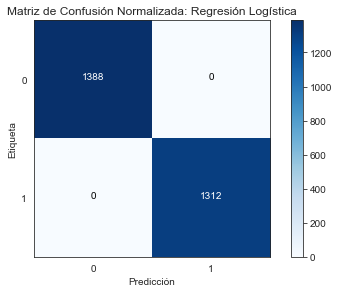

In [12]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train, y_train)

y_predict = model.predict(X_test)

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Regresión Logística')

### Redes Neuronales

Iteration 1, loss = 0.90309634
Iteration 2, loss = 0.86397456
Iteration 3, loss = 0.83245455
Iteration 4, loss = 0.80601696
Iteration 5, loss = 0.78366621
Iteration 6, loss = 0.76476996
Iteration 7, loss = 0.74892543
Iteration 8, loss = 0.73559569
Iteration 9, loss = 0.72385375
Iteration 10, loss = 0.71369729
Iteration 11, loss = 0.70461483
Iteration 12, loss = 0.69625830
Iteration 13, loss = 0.68827080
Iteration 14, loss = 0.68027639
Iteration 15, loss = 0.67179646
Iteration 16, loss = 0.66258943
Iteration 17, loss = 0.65223953
Iteration 18, loss = 0.64057373
Iteration 19, loss = 0.62737147
Iteration 20, loss = 0.61265097
Iteration 21, loss = 0.59650989
Iteration 22, loss = 0.57915919
Iteration 23, loss = 0.56098043
Iteration 24, loss = 0.54230823
Iteration 25, loss = 0.52355828
Iteration 26, loss = 0.50500075
Iteration 27, loss = 0.48688858
Iteration 28, loss = 0.46935376
Iteration 29, loss = 0.45252057
Iteration 30, loss = 0.43639489
Iteration 31, loss = 0.42103511
Iteration 32, los

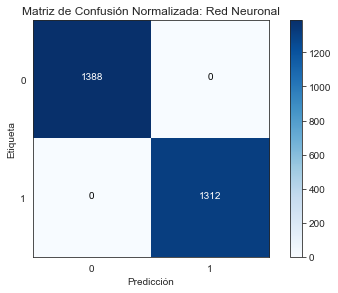

In [13]:
model = MLPClassifier( hidden_layer_sizes=(6, 4), activation='logistic', verbose=True ) # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
model.fit( X_train, y_train ) # Ajuste el modelo con los datos del conjunto A #
y_predict = model.predict( X_test ) # Realice la predicción de etiquetas con los datos de prueba del conjunto A #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(f'Sensibilidad {round(recall_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

